### MONTHLY BUDGET CALCULATION

This script takes as input:
- the total monthly precipitation and potential evapotranspiration over the catchment area (clipped from the ERA5 [monthly grouped] dataset reanalysis)
- the total monthly discharge measured in river catchments

the goal is to compare the two values and check quality of the measured catchments.

In [2]:
#import the needed libraries

from monthly_budget_f import get_monthly_discharge_from_DB, get_era5_monthly_DB, get_discharge_from_DB
import pandas as pd
import numpy as np
import os
from scipy import stats
import seaborn as sns
import calendar
from matplotlib import pyplot as plot



import sys, importlib
importlib.reload(sys.modules['monthly_budget_functions'])

### DEFINE THE PATH FOR THE MONTHLY PRECIPITATION AND P. EVAPOTRANSPIRATION DATASET

In [3]:
# era5 dataset precipitation (on the projectdata.eurac.edu respository)
era5file_p = 'Z:\ADO\ZAMG\DEPRECATED_QM\era5_uerra\monthly\\1979-2018_pr_qm_uerra-era5_monthly.nc'

# era5 dataset evaporation (monthly) (this file is shared on the ADO mysharepoint ADO/Documents/T2/resampled_era5  -> adjust the path accordingly)
era5file_pet = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\resampled_era5\potential_evapotranspiration-19790101_20181231-eusalp-qm_era5_month_sum.nc'

### INPUT GAUGING STATION: ENTER THE STAT_CODE WANTED

In [4]:
##### ADO SELECTED GAUGING STATIONS #####

### LARGE ALPINE RIVERS ###

STAT_CODE = 'ADO_DSC_ITC1_0020' # CASALE MONFERRATO PO
STAT_CODE = 'ADO_DSC_ITC1_0037' #PO SANT'ANTONIO

STAT_CODE = 'ADO_DSC_FRK2_0042'  #rhone viviers or valens? maybe better viviers
STAT_CODE = 'ADO_DSC_FRK2_0040' #RHONE VALENCE

STAT_CODE = 'ADO_DSC_AT12_0280'  #donau kienstock

STAT_CODE = 'ADO_DSC_CH03_0075'  #rheine basel

STAT_CODE = 'ADO_DSC_ITH2_0035'  #adige vo destro
STAT_CODE = 'ADO_DSC_ITH1_0012' #adige_bronzolo

### ADO CASE STUDIES ###

STAT_CODE = 'ADO_DSC_ITC1_0072' # orco_SAN BENIGNO
#STAT_CODE = 'ADO_DSC_ITC1_0060' # orco_basin -> PONT SOANA

STAT_CODE = 'ADO_DSC_CH04_0011'  #THURGAU_ANDELFINGEN (ALL THE REGION, BUT OUTSIDE THE ADMINISTRATIVE LIMIT)
STAT_CODE = 'ADO_DSC_CH05_0201' #THURGAU Halden (MUCH SMALLER)

STAT_CODE = 'ADO_DSC_CH07_0006' #ticino bellinzona (larger)
STAT_CODE = 'ADO_DSC_CH07_0147' #ticino pollegio campagna (solo da 86)
STAT_CODE = 'ADO_DSC_CH07_0100' #locarno soldurno.(solo da 86+ bilanci tornano poco)

STAT_CODE = 'ADO_DSC_AT31_0254' #upper-austria traun-wels
STAT_CODE = 'ADO_DSC_AT31_0206' #UA traun-lambach

STAT_CODE = 'ADO_DSC_FRK2_0041'  #DROME SAILLANS

STAT_CODE = 'ADO_DSC_SI03_0148' #DRAVINJA VIDEM (SLIGHTLY WRONG CATCHMENT AREA.)(ONLY PART OF THE STUDY AREA)(ONLY FROM 2001)
STAT_CODE = 'ADO_DSC_SI03_0033' #DRAVA DRAVOGRAD 

In [5]:
#get the monthly metereological input (from prec and evap ERA5) over the area of the selected basin
STAT_CODE = 'ADO_DSC_SI03_0067' #drava
meteo_df=get_era5_monthly_DB(STAT_CODE,era5file_pet,era5file_p)
meteo_df

,total_month_evap_m3,total_month_precip_m3
grouper,,
1979-01,8.112614e+05,3.048987e+07
1979-02,2.170294e+06,2.707054e+07
1979-03,1.017087e+07,2.052810e+07
1979-04,1.922806e+07,2.810718e+07
1979-05,3.543640e+07,1.859142e+07
...,...,...
2018-08,3.636098e+07,5.817917e+07
2018-09,2.023122e+07,3.987319e+07
2018-10,1.095679e+07,2.436082e+07


In [6]:
#get the discharge information
disch_df=get_monthly_discharge_from_DB(STAT_CODE)
disch_df.loc['2000']

,total_discharge_m_3,number
date,,
2000-01-31,7363008.0,31
2000-02-29,7057152.0,29
2000-03-31,7049376.0,31
2000-04-30,7723296.0,30
2000-05-31,5764608.0,31
2000-06-30,3394310.4,30
2000-07-31,3790627.2,31
2000-08-31,3000585.6,31
2000-09-30,2832624.0,30


In [7]:
# merge the discharge and meteo dataframe
df = pd.merge(disch_df.assign(grouper=disch_df.index.to_period('M')),
               meteo_df,
               how='inner', on='grouper')

# rename the columns, select the date as index
df.rename(columns={'grouper':'month','Q':'total_discharge_m_3'}, inplace=True)

df.index = df.month
df.drop(columns='month',inplace = True)

# compute the net intake in the basin (precipitation - evapotranspiration)
df['precipitation-evapotranspiration_m_3'] =df['total_month_precip_m3']-df['total_month_evap_m3']

In [8]:
df

,total_discharge_m_3,number,total_month_evap_m3,total_month_precip_m3,precipitation-evapotranspiration_m_3
month,,,,,
1979-01,17562528.0,31,8.112614e+05,3.048987e+07,2.967861e+07
1979-02,16994016.0,28,2.170294e+06,2.707054e+07,2.490025e+07
1979-03,18342720.0,31,1.017087e+07,2.052810e+07,1.035723e+07
1979-04,17252352.0,30,1.922806e+07,2.810718e+07,8.879117e+06
1979-05,11552544.0,31,3.543640e+07,1.859142e+07,-1.684498e+07
...,...,...,...,...,...
2018-08,6325776.0,31,3.636098e+07,5.817917e+07,2.181819e+07
2018-09,6324739.2,30,2.023122e+07,3.987319e+07,1.964197e+07
2018-10,4847126.4,31,1.095679e+07,2.436082e+07,1.340402e+07


### PLOT THE TIME SERIES FOR THE 3 VARIABLES

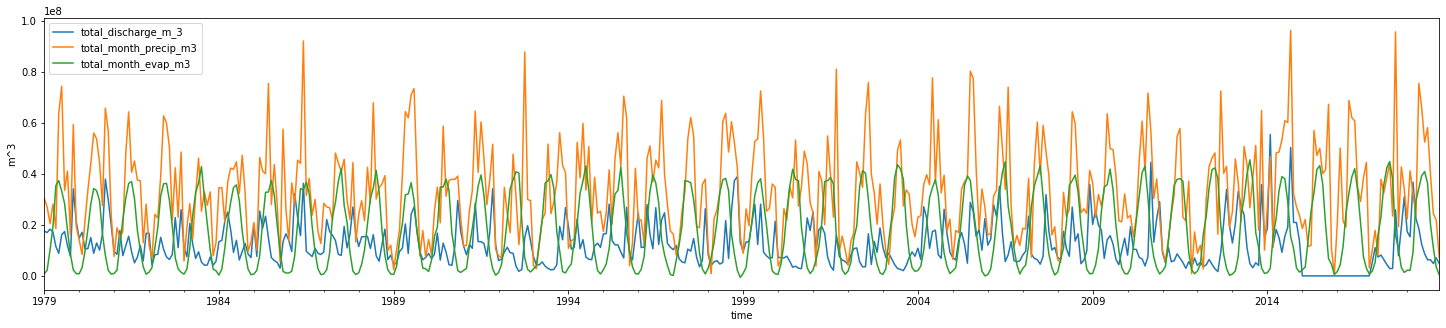

In [9]:
ax=df.plot.line(y=['total_discharge_m_3','total_month_precip_m3','total_month_evap_m3'],
                      #title=name+' BASIN',
                      figsize=(25,5),
                      ylabel='m^3',
                      xlabel='time')

### COMPUTE THE CUMULATE OVER THE WATER YEAR

In [10]:
df['hydro_year']= df.index.year

df.loc[df.index.month>9,'hydro_year'] = df[df.index.month>9].index.year+1

df_cum = df.groupby(df.hydro_year).cumsum()
df_cum['hydro_year']= df_cum.index.year
df_cum.loc[df_cum.index.month>9,'hydro_year'] = df_cum[df_cum.index.month>9].index.year+1

### PLOT THE CUMULATIVE GRAPHS FOR THE WATER YEARS

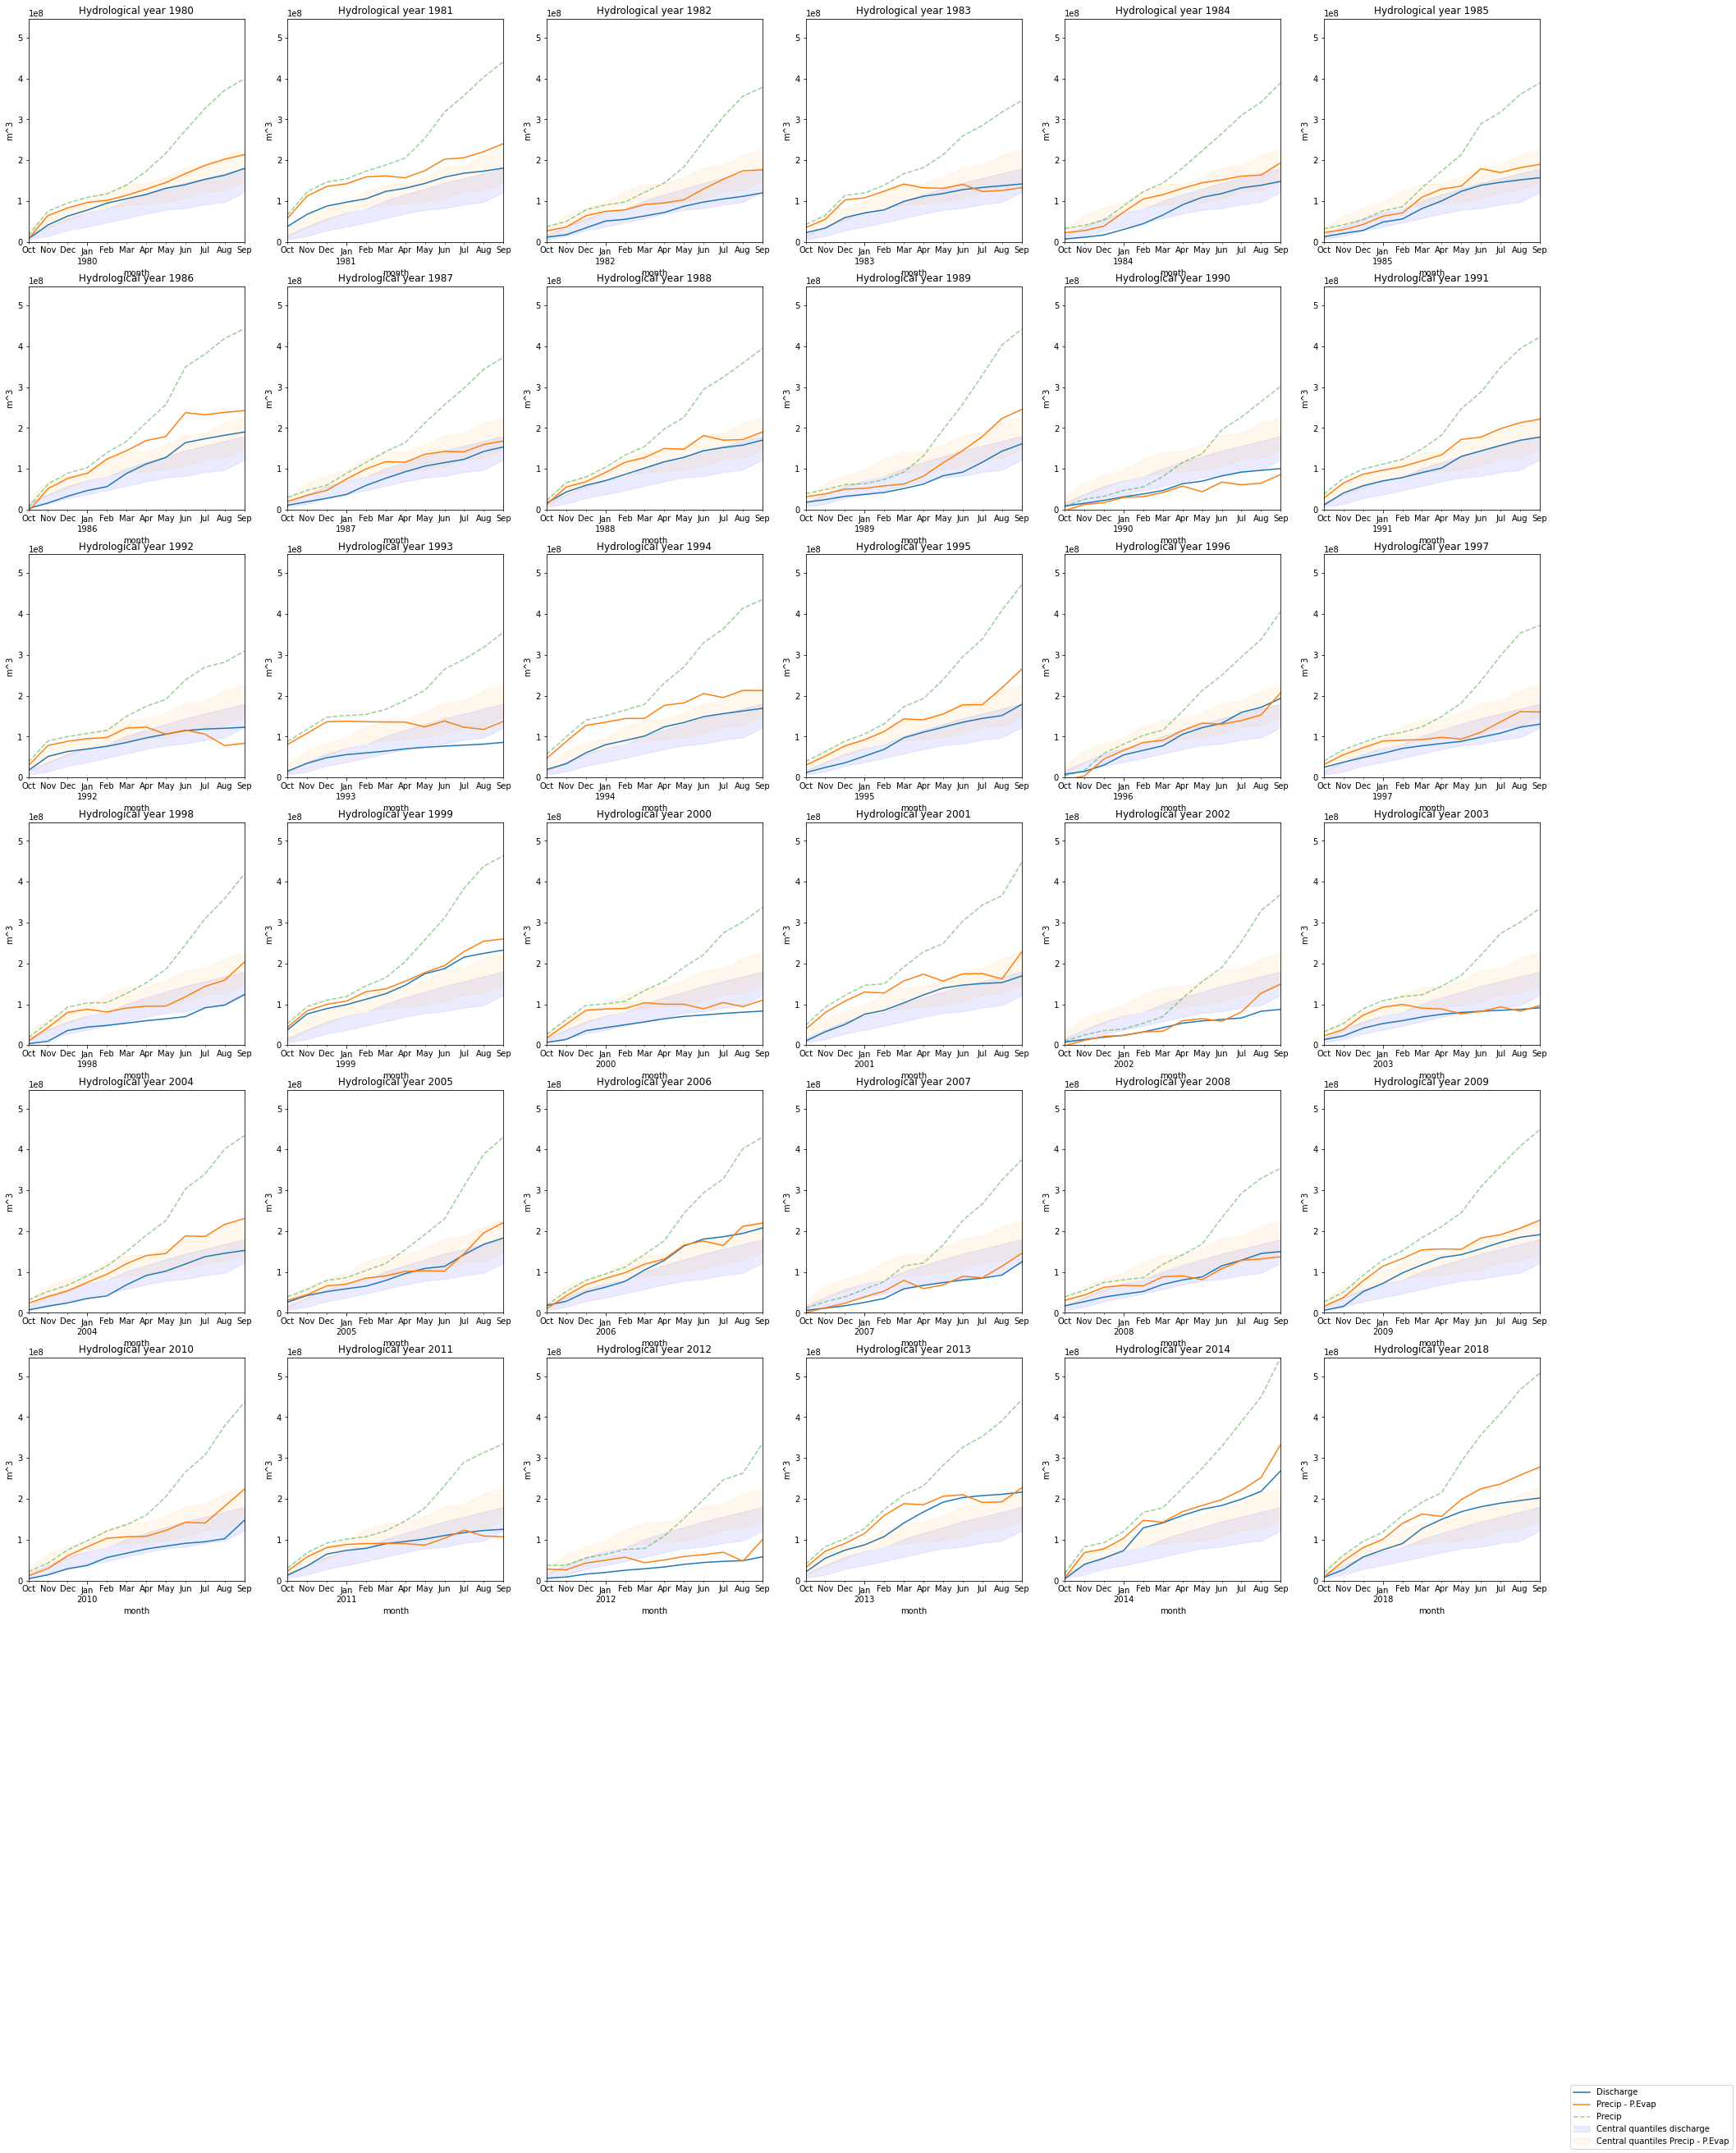

In [11]:
#compute 1st and 4th quartile (from the climathology available)
df_cum75=df_cum.groupby(by=df_cum.index.month).quantile(q=0.75)
df_cum25=df_cum.groupby(by=df_cum.index.month).quantile(q=0.25)

#define firs
start_year = df_cum['hydro_year'][0]
yline=df_cum[df_cum.index.month==9][['total_discharge_m_3']].mean()[0]

#define the height of the graph (by taking the max precipitation)
ylimit= df_cum.loc[:,'total_month_precip_m3'].max()

fig=plot.figure(figsize=(33,41))
#fig.suptitle('Cumulative water year balance',fontweight="bold")

#for every year
j=1
for i in df_cum['hydro_year'].unique():
    
    #print only if the data is complete
    if df_cum[df_cum['hydro_year']==i].iloc[-1].number >=365:
        plot.subplot(7,6,j)
        
        #plot the discharge and net intake
        df_cum[df_cum['hydro_year']==i].plot.line(y=['total_discharge_m_3','precipitation-evapotranspiration_m_3'],
                                                  title='Hydrological year '+ str(i),
                                                  legend=None,
                                                  ylim=(0,ylimit),
                                                  
                                                  ylabel='m^3',
                                                  rot=45,
                                                  ax=plot.gca())
        
        #fill the central quantiles of discharge 
        plot.fill_between(x=df_cum[df_cum['hydro_year']==i].index,
                          y1=df_cum75.total_discharge_m_3.loc[df_cum[df_cum['hydro_year']==i].index.month],
                          y2=df_cum25.total_discharge_m_3.loc[df_cum[df_cum['hydro_year']==i].index.month],
                         alpha=0.08, color='blue')
        
        #fill the central quantiles of net intake
        plot.fill_between(x=df_cum[df_cum['hydro_year']==i].index,
                  y1=df_cum75['precipitation-evapotranspiration_m_3'].loc[df_cum[df_cum['hydro_year']==i].index.month],
                  y2=df_cum25['precipitation-evapotranspiration_m_3'].loc[df_cum[df_cum['hydro_year']==i].index.month],
                 alpha=0.08, color='orange')

        
        #plot rhe precipitation with a dashed line.
        df_cum[df_cum['hydro_year']==i].plot.line(y=['total_month_precip_m3'],
                                                  linestyle='dashed',
                                                  alpha=0.5,
                                                  legend=None,
                                                  ax=plot.gca())
        
        #update j      
        j=j+1
        
        
fig.tight_layout
fig.legend(['Discharge','Precip - P.Evap ','Precip', 'Central quantiles discharge', 'Central quantiles Precip - P.Evap'],loc='lower right')

### PLOT THE WATER YEAR TOTAL DISCHARGE AND NET INTAKE OF THE BASIN

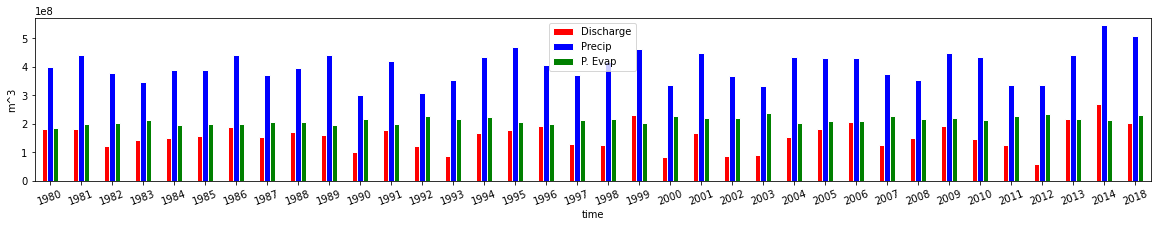

In [12]:
df_wyear = df.groupby(df.hydro_year).sum()
df_wyear.drop(df_wyear[df_wyear.number < 365].index,inplace=True)
dictio={"total_discharge_m_3" : "Discharge",
        "total_month_precip_m3" : "Precip",
        "total_month_evap_m3"      : "P. Evap"
       }
       
df_wyear = df_wyear.rename(columns=dictio)
ax = df_wyear.plot.bar(y=['Discharge','Precip','P. Evap'],
                      #title=name+' BASIN',
                      figsize=(20,3),
                      ylabel='m^3',
                      xlabel='time',
                      color=['red', 'blue', 'green'],
                      rot=20,
                      legend='best',
                      edgecolor='white')



### SHOW THE WATER YEAR TOTAL BUDGET

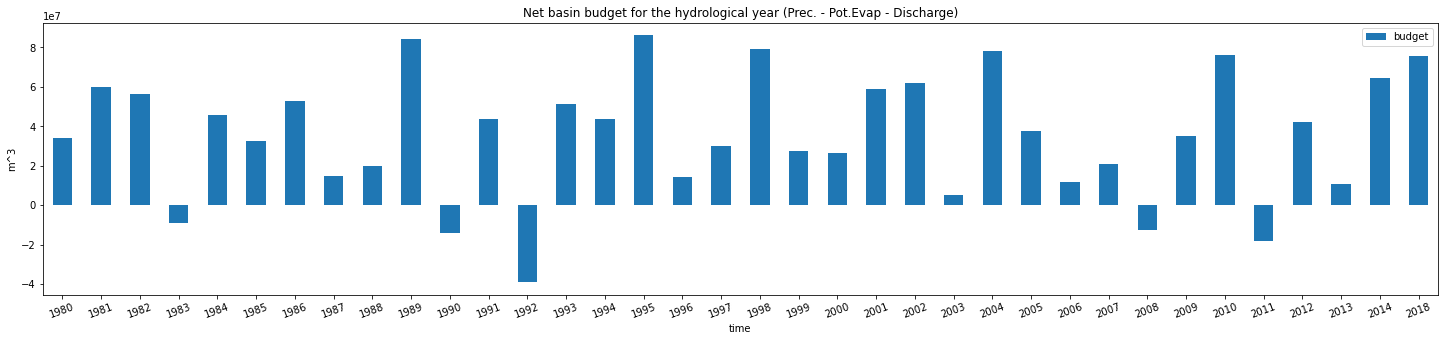

In [13]:
df_wyear['budget']=df_wyear['precipitation-evapotranspiration_m_3']  -  df_wyear['Discharge']
ax = df_wyear.plot.bar(y='budget',
                      #title=name+' BASIN',
                      figsize=(25,5),
                      ylabel='m^3',
                      xlabel='time',
                      rot=20,
                      title='Net basin budget for the hydrological year (Prec. - Pot.Evap - Discharge)')

#### COMPUTE THE BUDKYO INDEX

<Figure size 432x288 with 0 Axes>

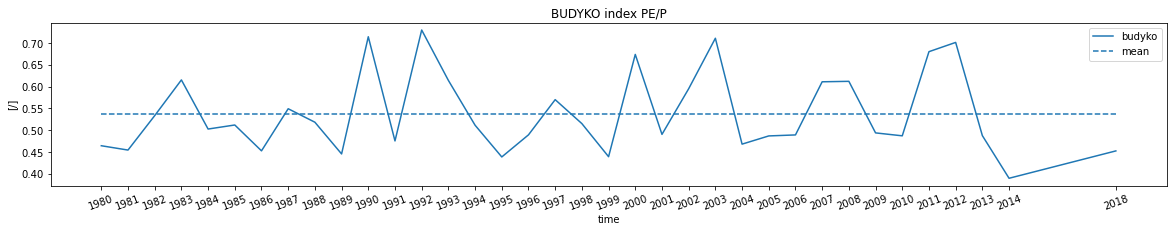

In [14]:
#ADD A LINE WITH THE BUDYKO INDEX
df_wyear.loc[:,'budyko'] = df_wyear.loc[:,'P. Evap']/df_wyear.loc[:,'Precip']
fig = plot.figure()


df_wyear.plot.line(y='budyko',
                      #title=name+' BASIN',
                      figsize=(20,3),
                      ylabel='[/]',
                      xlabel='time',
                      xticks=df_wyear.index,
                      rot=20,
                      title='BUDYKO index PE/P')


plot.hlines(df_wyear.loc[:,'budyko'].mean(), df_wyear.index.min(), df_wyear.index.max(), linestyles='dashed',label='mean')
#df_wyear.loc[:,'budkyo'].mean()
#df_wyear['pred'].plot.line(color='red', linewidth=3,use_index = True)
plot.legend()
fig.tight_layout()

 ## DISCHARGE YEARLY PATTERNS ANALYSIS

Text(0.5, 1.0, 'BOX-PLOT of Discharge Climatology')

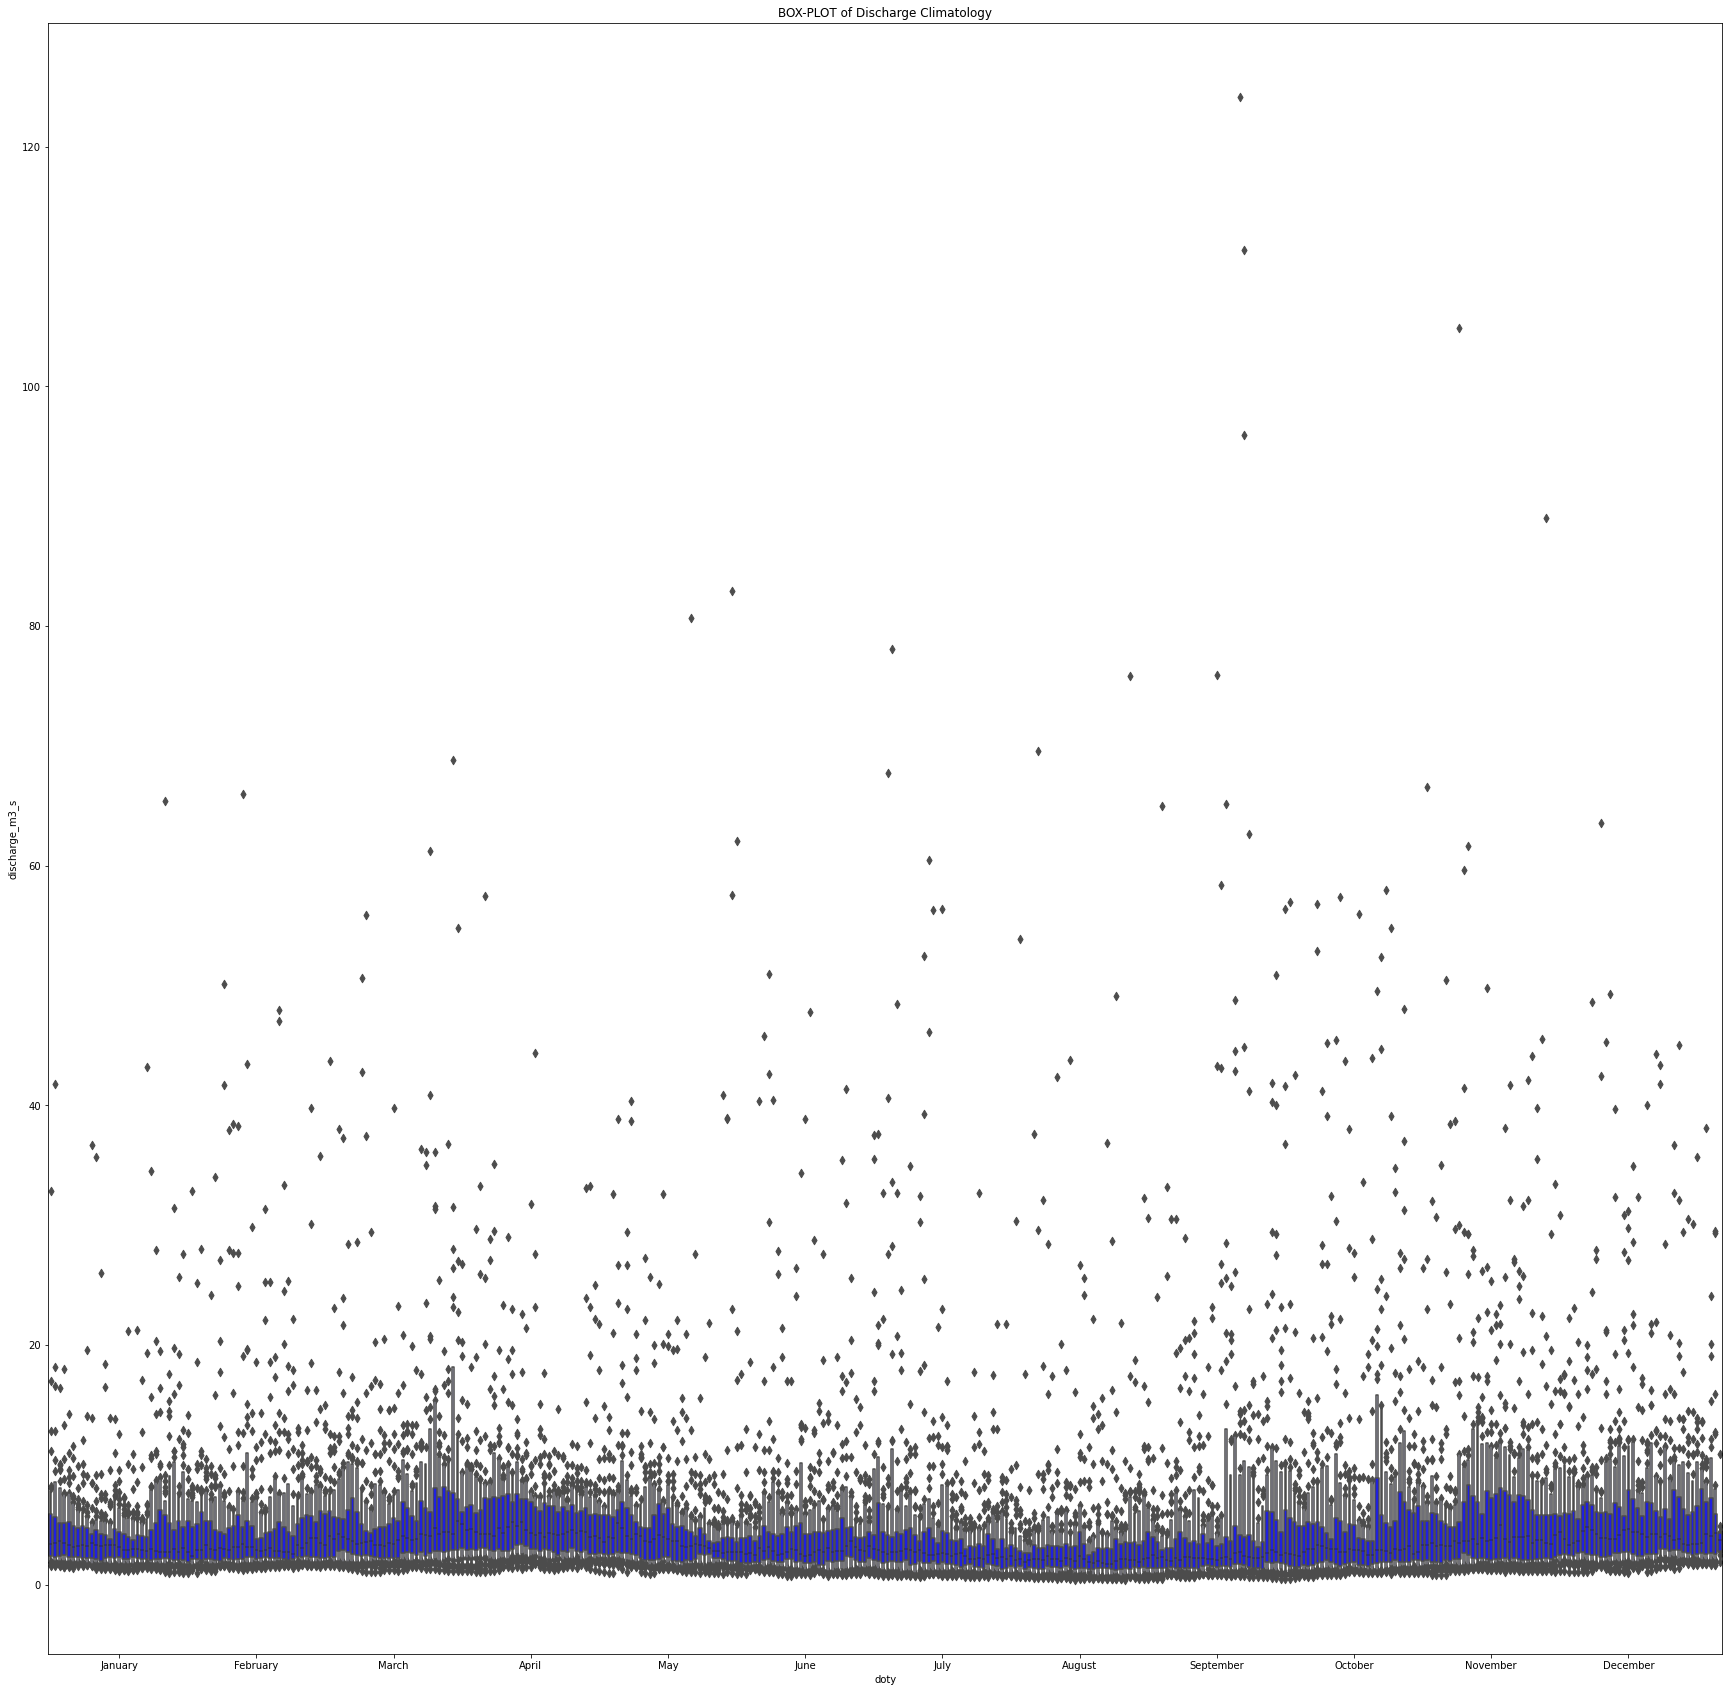

In [15]:
#get DAILY DISCHARGE
runoff= get_discharge_from_DB(STAT_CODE)

runoff['doty']=runoff.index.day_of_year

plot.figure(figsize=(30,30))

g=sns.boxenplot(x="doty", y="discharge_m3_s",
               data=runoff,color="b",scale="linear",)

#g=sns.lineplot(x="doty", y="discharge_m3_s",
#              data=runoff, palette=['red'])

g.set_xticks((range(15,365,30)))
g.set_xticklabels(list(calendar.month_name)[1:])
plot.title('BOX-PLOT of Discharge Climatology')